In [1]:
!pip install transformers torch seaborn matplotlib

In [2]:
!pip install openpyxl


In [3]:
!pip uninstall pandas -y
!pip install pandas


Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
import pandas as pd

# Ganti 'Modified_SQL_Dataset.xlsx' dengan nama file Excel yang Anda gunakan
data = pd.read_excel('/content/Modified_SQL_Dataset.xlsx')


# Melihat beberapa baris pertama dan informasi umum dari dataset
print("Informasi Dataset:")
print(data.info())
print("\nContoh Data:")
print(data.head())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30909 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB
None

Contoh Data:
                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1


In [5]:
print(data.columns)

Index(['Query', 'Label'], dtype='object')


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

# Menghapus baris dengan nilai null
data.dropna(inplace=True)

# Menggunakan LabelEncoder untuk mengonversi label
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Membagi data menjadi data latih dan uji
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Query'], data['Label'], test_size=0.2, random_state=42)

# Tokenisasi menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Pastikan semua data teks adalah string dan hilangkan nilai kosong
train_texts = train_texts.fillna("").astype(str)
test_texts = test_texts.fillna("").astype(str)

# Tokenisasi ulang
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
import torch
from torch.utils.data import Dataset

# Definisi Dataset
class SQLInjectionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_numpy()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Pastikan `train_labels`, `test_labels`, `train_encodings`, dan `test_encodings` didefinisikan
# dan sinkronisasi sudah dilakukan
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)
train_dataset = SQLInjectionDataset(train_encodings, train_labels)
test_dataset = SQLInjectionDataset(test_encodings, test_labels)

from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Menginisialisasi model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Pengaturan parameter pelatihan
training_args = TrainingArguments(
    output_dir='./results',               # Direktori output
    num_train_epochs=3,                   # Jumlah epoch
    per_device_train_batch_size=8,        # Batch size untuk data latih
    per_device_eval_batch_size=16,        # Batch size untuk data uji
    warmup_steps=500,                     # Warmup steps
    weight_decay=0.01,                    # Weight decay
    logging_dir='./logs',                 # Direktori log
    eval_strategy="epoch",                # Evaluasi setiap akhir epoch (pengganti evaluation_strategy)
    fp16=True                             # Mixed Precision jika didukung oleh GPU
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Melatih model
trainer.train()

# Evaluasi model
results = trainer.evaluate()
print(results)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.015300,0.028461
2,0.006400,0.009358
3,0.001300,0.007260


{'eval_loss': 0.0072601474821567535, 'eval_runtime': 11.8349, 'eval_samples_per_second': 522.354, 'eval_steps_per_second': 32.7, 'epoch': 3.0}


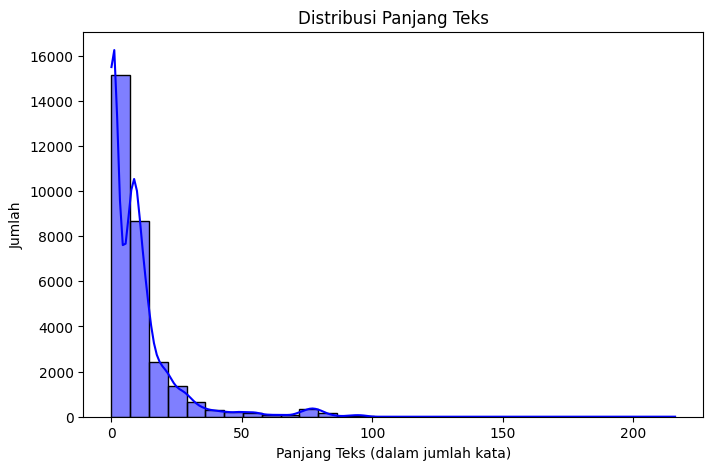

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan `train_texts` dan `train_labels` sudah ada sebagai data pelatihan Anda
df_train = pd.DataFrame({'text': train_texts, 'label': train_labels})

# Konversi kolom 'text' menjadi string, dan atasi NaN dengan string kosong ("") agar .split() tidak error
df_train['text'] = df_train['text'].fillna("").astype(str)

# 2. Visualisasi Panjang Teks Sebelum Tokenisasi
text_lengths = [len(text.split()) for text in df_train['text']]
plt.figure(figsize=(8, 5))
sns.histplot(text_lengths, bins=30, kde=True, color='blue')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks (dalam jumlah kata)')
plt.ylabel('Jumlah')
plt.show()


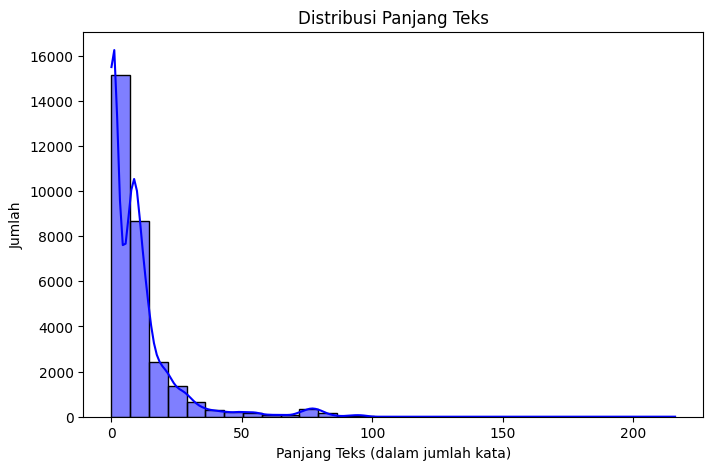

In [12]:
# Konversi kolom 'text' menjadi string, dan atasi NaN dengan string kosong ("") agar .split() tidak error
df_train['text'] = df_train['text'].fillna("").astype(str)

# 2. Visualisasi Panjang Teks Sebelum Tokenisasi
text_lengths = [len(text.split()) for text in df_train['text']]
plt.figure(figsize=(8, 5))
sns.histplot(text_lengths, bins=30, kde=True, color='blue')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks (dalam jumlah kata)')
plt.ylabel('Jumlah')
plt.show()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.026000,0.051213,0.991103,0.991264,0.991103,0.991122
2,0.011000,0.009279,0.998544,0.998544,0.998544,0.998544
3,0.001600,0.005255,0.999353,0.999353,0.999353,0.999353


ValueError: x and y must have same first dimension, but have shapes (18,) and (4,)

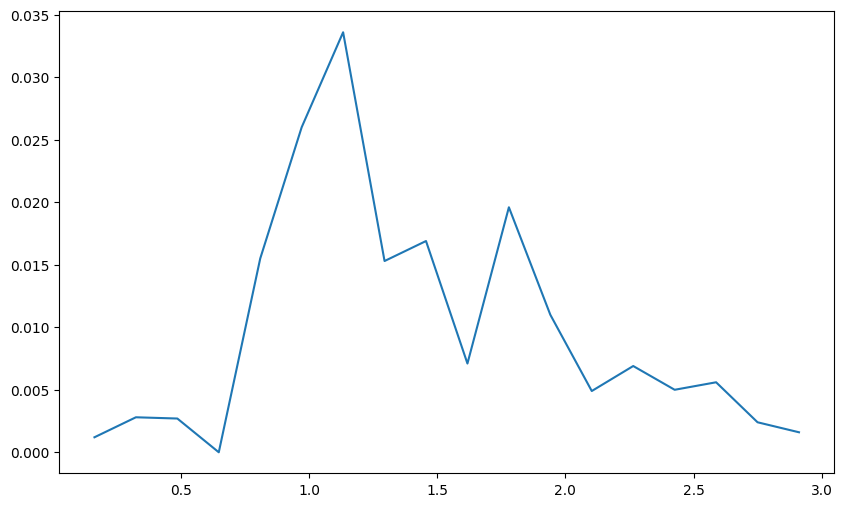

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Fungsi untuk menghitung metrik evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Menyiapkan Trainer dengan compute_metrics yang diperbarui
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Melatih model dan menyimpan log
train_output = trainer.train()
trainer.save_model()

# Evaluasi model
eval_results = trainer.evaluate()

# Ekstrak metrik pelatihan dan evaluasi dari log history Trainer
training_logs = trainer.state.log_history
epochs = [log["epoch"] for log in training_logs if "loss" in log]
training_losses = [log["loss"] for log in training_logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
eval_accuracies = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]
eval_precisions = [log["eval_precision"] for log in training_logs if "eval_precision" in log]
eval_recalls = [log["eval_recall"] for log in training_logs if "eval_recall" in log]
eval_f1s = [log["eval_f1"] for log in training_logs if "eval_f1" in log]

# Visualisasi metrik
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label="Training Loss")
plt.plot(epochs, eval_losses, label="Evaluation Loss")
plt.plot(epochs, eval_accuracies, label="Evaluation Accuracy")
plt.plot(epochs, eval_precisions, label="Evaluation Precision")
plt.plot(epochs, eval_recalls, label="Evaluation Recall")
plt.plot(epochs, eval_f1s, label="Evaluation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Metrik")
plt.title("Metrik Pelatihan dan Evaluasi per Epoch")
plt.legend()
plt.show()


Panjang epochs: 18
Panjang training_losses: 18
Panjang eval_accuracies: 4


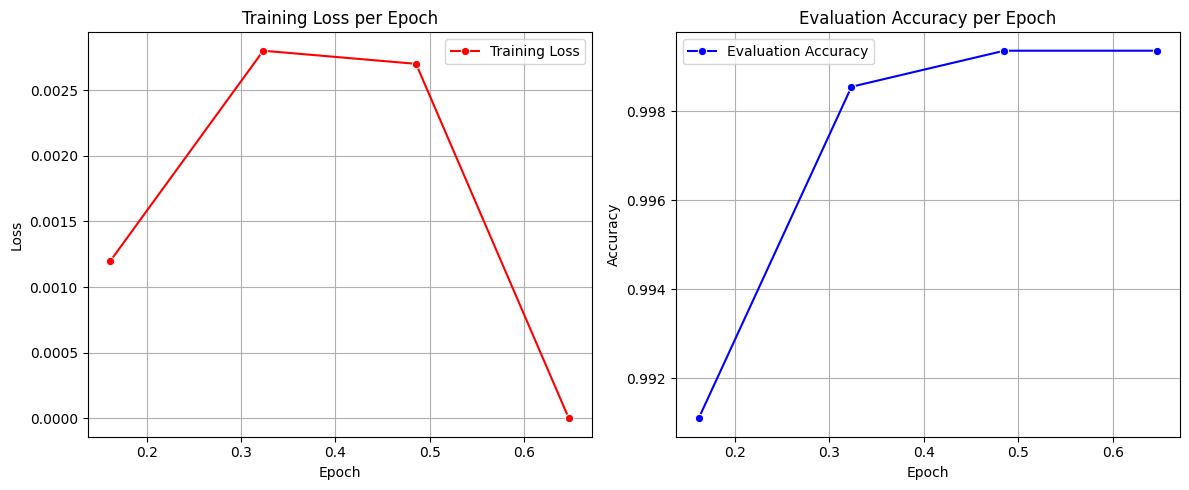

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan semua variabel memiliki panjang yang sama
print(f"Panjang epochs: {len(epochs)}")
print(f"Panjang training_losses: {len(training_losses)}")
print(f"Panjang eval_accuracies: {len(eval_accuracies)}")

# Sesuaikan panjang variabel (jika perlu) agar semua memiliki panjang yang sama
min_length = min(len(epochs), len(training_losses), len(eval_accuracies))
epochs = epochs[:min_length]
training_losses = training_losses[:min_length]
eval_accuracies = eval_accuracies[:min_length]

# Visualisasi Training Loss dan Evaluation Accuracy
plt.figure(figsize=(12, 5))

# Subplot untuk Training Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=training_losses, marker='o', color='red', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Subplot untuk Evaluation Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=eval_accuracies, marker='o', color='blue', label='Evaluation Accuracy')
plt.title('Evaluation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
